In [1]:
import dask
from dask.distributed import Client, LocalCluster
import xarray as xr
import numpy as np
import  matplotlib.pyplot as plt
import os
from ipywidgets import Image
from ipywidgets import ColorPicker, IntSlider, link, AppLayout, HBox
from ipycanvas import  hold_canvas,  MultiCanvas #RoughCanvas,Canvas,
import imageio

In [2]:
# local cluster on current machine
cluster = LocalCluster(dashboard_address=':35154' ) 
client = Client(cluster)
print('Dashboard at '+cluster.dashboard_link)

2022-09-06 15:51:40,399 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-el_1exv9', purging


Dashboard at http://127.0.0.1:35154/status


In [3]:
# # home-made cluster
# scheduler_address = "129.129.188.248:8786"
# client = Client(scheduler_address)
# print('Dashboard at '+client.dashboard_link)

In [4]:
# tempfolder = '/mnt/SSD_2TB_nvme0n1/Robert'

In [5]:
# dask.config.config['temporary-directory'] = tempfolder

In [6]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35154/status,
Dashboard: http://127.0.0.1:35154/status,Workers: 5
Total threads: 20,Total memory: 503.62 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43858,Workers: 5
Dashboard: http://127.0.0.1:35154/status,Total threads: 20
Started: Just now,Total memory: 503.62 GiB
Comm: tcp://127.0.0.1:44688,Total threads: 4
Dashboard: http://127.0.0.1:44053/status,Memory: 100.72 GiB
Nanny: tcp://127.0.0.1:41077,


In [7]:
from filter_functions import image_filter

In [8]:
import training_functions as tfs
from training_functions import train_segmentation


In [9]:
def on_mouse_down(x, y):
    global drawing
    global position
    global shape
    drawing = True
    position = (x, y)
    shape = [position]

def on_mouse_move(x, y):
    global drawing
    global position
    global shape
    if not drawing:
        return
    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        position = (x, y)
    shape.append(position)

def on_mouse_up(x, y):
    global drawing
    global positiondu
    global shape
    drawing = False
    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        canvas.fill_polygon(shape)
    shape = []

In [10]:
path = '/home/fische_r/NAS/testing/Jeremy_tomo/tomodata.nc'
featpath = '/home/fische_r/NAS/testing/Jeremy_tomo/featdata.nc'
# path = r"C:\Zwischenlager\tomodata.nc"
# path = '/mpc/homes/fische_r/wood3/wood_tomo.nc'
# featpath = '/mpc/homes/fische_r/wood3/featdata.nc'

path = '/home/fische_r/NAS/testing/TIM_tomo/tomodata.nc'
featpath = '/home/fische_r/NAS/testing/TIM_tomo/featdata.nc'

In [11]:
# chunksize = (40, 35, 40, 37)
chunks = {'x': 40, 'y':35, 'z':40, 'time':37}

In [12]:
IF = image_filter(data_path=path, outpath = featpath, chunksize='auto')

In [13]:
# IF.open_raw_data()

In [14]:
IF.open_lazy_data()

AttributeError: 'Dataset' object has no attribute 'tomo'

In [15]:
# IF.data = IF.data[30:-20,15:-50,:100,:50] #cropping for wood

In [15]:
test = xr.open_dataset(IF.data_path, chunks = 'auto')

In [16]:
test

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [16]:
IF.data

,Array,Chunk
Bytes,328.56 GiB,126.15 MiB
Shape,"(1781, 140, 956, 185)","(137, 14, 233, 37)"
Count,3251 Tasks,3250 Chunks
Type,float64,xarray.core.dataarray.DataArray


In [17]:
IF.prepare()

In [18]:
IF.stack_features()

In [19]:
IF.feature_stack

,Array,Chunk
Bytes,24.06 TiB,126.15 MiB
Shape,"(1781, 140, 956, 185, 75)","(137, 14, 233, 37, 1)"
Count,4074146 Tasks,243750 Chunks
Type,float64,numpy.ndarray


In [20]:
# IF.compute() #not sure what is more efficient, but I would compute the features and even store them on disk
# had the impression that otherwise many redundant operations happen

In [21]:
IF.make_xarray_nc()

In [22]:
# IF.make_xarray_nc(store=True)

In [23]:
# training_path = r"C:\Zwischenlager\Jeremy_tomo"
training_path = '/home/fische_r/NAS/testing/Jeremy_tomo'
training_path = '/mpc/homes/fische_r/wood3/'
training_path = '/home/fische_r/NAS/testing/TIM_tomo'
if not os.path.exists(training_path):
    os.mkdir(training_path)

In [24]:
TS = train_segmentation(training_path=training_path)

In [25]:
TS.import_lazy_feature_data(IF.result, IF.original_dataset)

In [26]:
# TS.import_feature_data(IF.result)

### iterative training, if you have a training set, skip here

In [27]:
TS.suggest_training_set()

You could try  z = 683  and  time = 149
However, please sort it like the original xyztime


In [50]:
c1 = 'y'
p1 = 84
c2 = 'time'
p2 = 170

In [51]:
TS.load_training_set(c1, p1, c2, p2)

In [52]:
# TS.current_im8 = TS.current_im8.compute()

In [53]:
alpha = 0.15
im8 = TS.current_im8
resultim = TS.current_result
width = im8.shape[1]
height = im8.shape[0]
Mcanvas = MultiCanvas(4, width=width, height=height)
background = Mcanvas[0]
resultdisplay = Mcanvas[2]
truthdisplay = Mcanvas[1]
canvas = Mcanvas[3]
canvas.sync_image_data = True
drawing = False
position = None
shape = []
image_data = np.stack((im8, im8, im8), axis=2)
background.put_image_data(image_data, 0, 0)
resultdisplay.global_alpha = alpha
if np.any(resultim>0):
    result_data = np.stack((255*(resultim==0), 255*(resultim==1), 255*(resultim==2)), axis=2)
else:
    result_data = np.stack((0*resultim, 0*resultim, 0*resultim), axis=2)
resultdisplay.put_image_data(result_data, 0, 0)
canvas.on_mouse_down(on_mouse_down)
canvas.on_mouse_move(on_mouse_move)
canvas.on_mouse_up(on_mouse_up)
picker = ColorPicker(description="Color:", value="#ff0000")
slidealpha = IntSlider(description="Result overlay", value=0.15)
link((picker, "value"), (canvas, "stroke_style"))
link((picker, "value"), (canvas, "fill_style"))
HBox((Mcanvas, picker, slidealpha))

In [54]:
# tfs.plot_im_histogram(TS.current_im8)
# TS.current_im8 = tfs.adjust_image_contrast(TS.current_im8, 50,255)

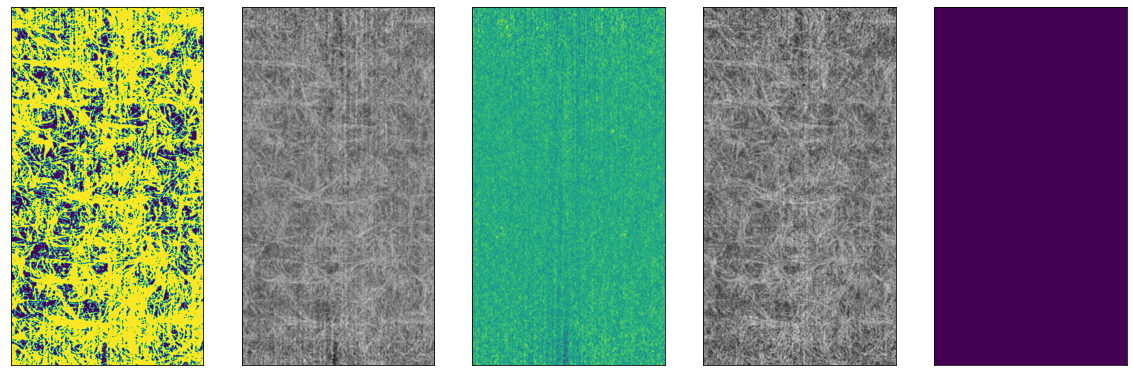

In [58]:
fig, axes = plt.subplots(1,5, figsize=(20,10))
axes[0].imshow(TS.current_result)
axes[1].imshow(TS.current_im8, 'gray')
axes[2].imshow(TS.current_diff_im)
# axes[3].imshow(m8old, 'gray')
axes[3].imshow(TS.current_first_im, 'gray')
axes[4].imshow(TS.current_truth)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

In [56]:
label_set = canvas.get_image_data()

TS.current_truth[label_set[:,:,0]>0] = 1
TS.current_truth[label_set[:,:,1]>0] = 2
TS.current_truth[label_set[:,:,2]>0] = 4

imageio.imsave(TS.current_truthpath, TS.current_truth)

In [57]:
TS.train_slice()

now actually calculating the features
training and classifying


In [704]:
# TS.current_im8 = tfs.adjust_image_contrast(TS.current_im8, 50,200)

### when done, maybe save the classifier

In [706]:
TS.pickle_classifier()

### use an existing trainingset to train classifier (adhere to label iamge naming convention)

In [24]:
# TS.feat_data = TS.feat_data.compute() #better option for retraining, but creates a numpy array, maybe you can avoid

In [26]:
# provide new feature data if necessary and say if it is a lazy dask array or not
# TS.feat_data = 
# TS.lazy = 

TS.train()

Need to actually calculate the features for each slice, seems inefficient


2022-09-01 17:08:57,360 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-09-01 17:08:57,361 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-09-01 17:08:57,362 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-09-01 17:08:57,363 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-09-01 17:08:57,362 - distributed.worker - WARNING - Heartbeat to scheduler failed
Traceback (most recent call last):
  File "/home/fische_r/miniconda3/lib/python3.9/site-packages/distributed/comm/tcp.py", line 223, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/fische_r/miniconda3/lib/python3.9/site-packages/distributed/worker.py", line 1159, in heartbeat
    response = await retry_operation(
  File "/home/fische_r/miniconda3/lib/python3.9/site-packages/d

KeyboardInterrupt: 

In [26]:
# TS.pickle_classifier()

In [27]:
from segmentation import segmentation
# import pickle

In [24]:
SM = segmentation(training_path = training_path, classifier_path=os.path.join(training_path, 'classifier.p'))

In [28]:
# SM.import_classifier(TS.clf)
# SM.clf = pickle.load(open(os.path.join(training_path, 'classifier.p'), 'rb'))

In [29]:
SM.import_feature_data(IF.result)

In [39]:
# SM.lazy = False
part2 = SM.feat_data.feature_stack[:,:,:,25:,:]

In [40]:
num_feat = part2.shape[-1]
clf = SM.clf
seg2 = clf.predict(part2.data.reshape(-1,num_feat))
seg2 = seg2.reshape(part2[...,0].shape).astype(np.uint8)

In [38]:
# seg1 = seg1.reshape(part1[...,0].shape).astype(np.uint8)

In [ ]:
# SM.classify_all()

classifying ...


In [707]:
# SM.store_segmented_data()

In [49]:
seg_data.size/1024**3

0.2153683453798294

In [47]:
path = os.path.join(SM.training_path, 'segmented.nc')

#TODO: propagate labels from raw data
#TODO: if self.segmented_data is a dask array, rechunk for saving
shp = seg_data.shape
data = xr.Dataset({'segmented': (['x','y','z','time'], seg_data)},
                               coords = {'x': np.arange(shp[0]),
                               'y': np.arange(shp[1]),
                               'z': np.arange(shp[2]),
                               'time': np.arange(shp[3]),
                               'feature': SM.feature_names}
                     )
# data.to

In [50]:
data.to_netcdf(path)

In [51]:
TS.plot_importance()

NameError: name 'TS' is not defined

/tmp/ipykernel_835997/3278944968.py:2: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(TS.feature_names, TS.clf.feature_importances_,'x')


Text(0, 0.5, 'importance')

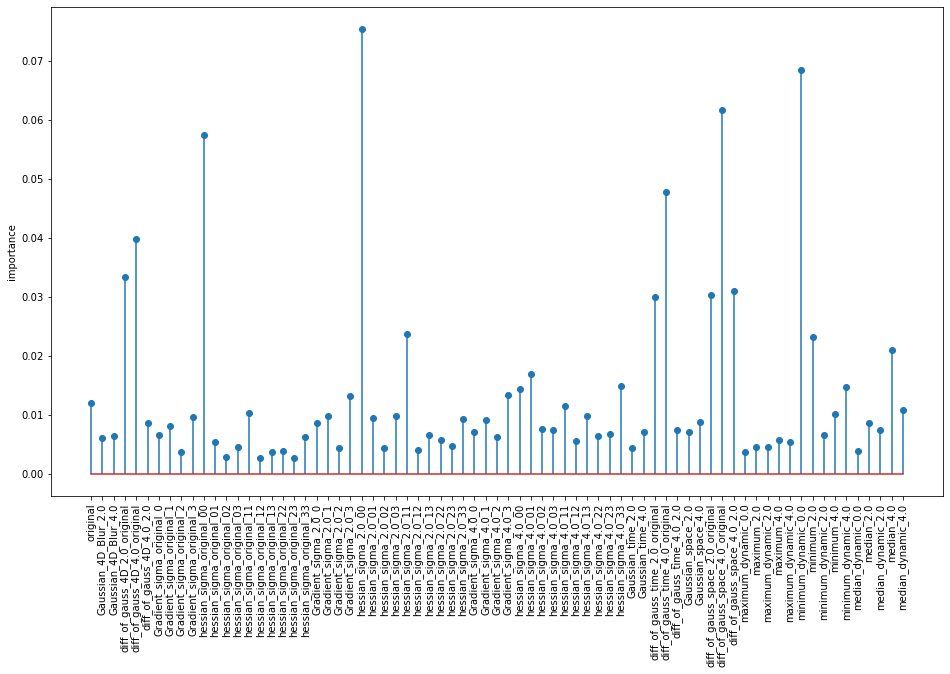

In [632]:
plt.figure(figsize=(16,9))
plt.stem(TS.feature_names, TS.clf.feature_importances_,'x')
plt.xticks(rotation=90)
plt.ylabel('importance') 

/tmp/ipykernel_870706/1913450262.py:2: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(SM.feature_names, clf.feature_importances_,'x')


Text(0, 0.5, 'importance')

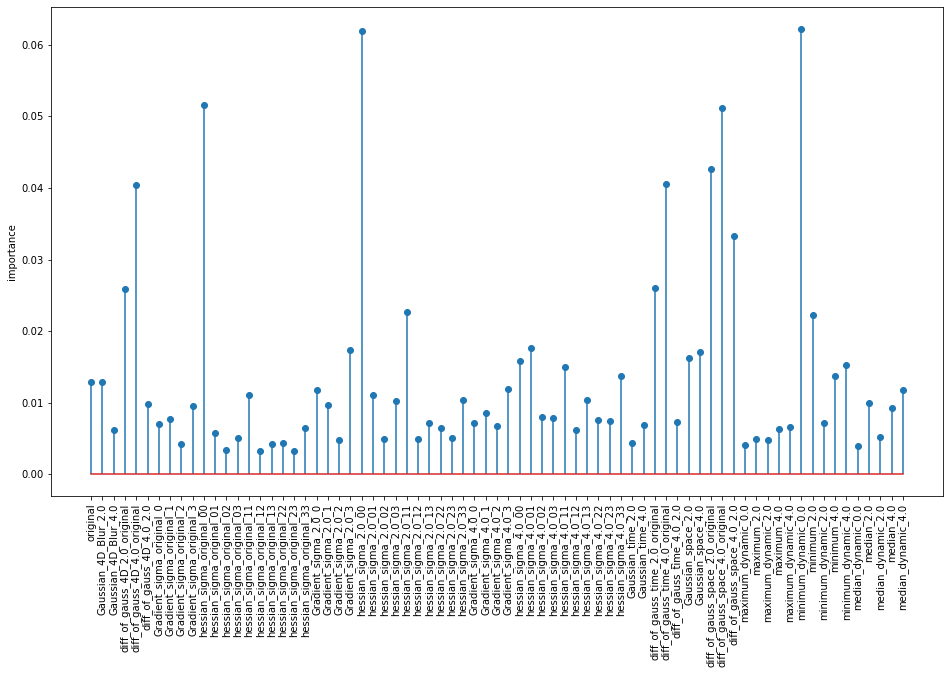

In [52]:
plt.figure(figsize=(16,9))
plt.stem(SM.feature_names, clf.feature_importances_,'x')
plt.xticks(rotation=90)
plt.ylabel('importance') 

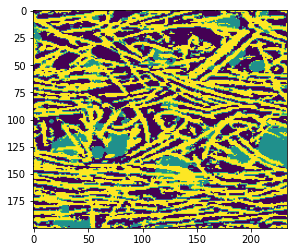

In [49]:
plt.imshow(SM.segmented_data[:,10,:,-1])